In [59]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from scipy.integrate import ode 
from kuramoto import * # import the kuramoto classes from file 

## First, we do some 1D simulations.  

In [83]:
# Set up model parameters 
epsilon = 1
gamma = 0.7
sigma = 0.05
mean_omega = 0.2

# Set up simulation parameters 
L = 256 # size of the system 
T = 1e3 # total time of the simulation 
dt = 1e-3 # time step 
n_batches = T # number of time points recorded in the end 

# Initialise the model and run the simulation 
model = Kuramoto(epsilon, gamma, sigma, mean_omega, BC='fixed')
model.initialise(L, T, dt, n_batches)
model.evolve(verbose=False) # this runs the simulation, set verbose to True to see output at every time step 

## Then, we plot the spacetime graph of the phase evolution 

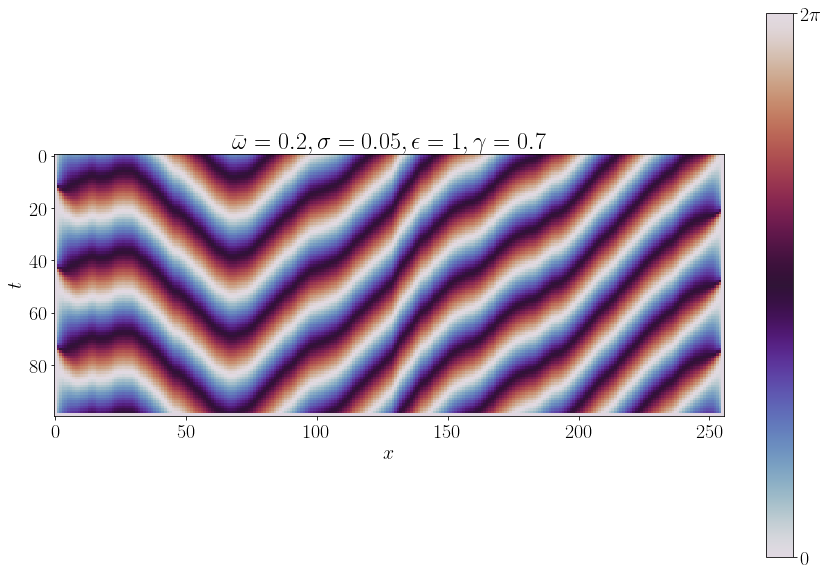

In [84]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(model.res[-100:] % (np.pi*2), cmap='twilight', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

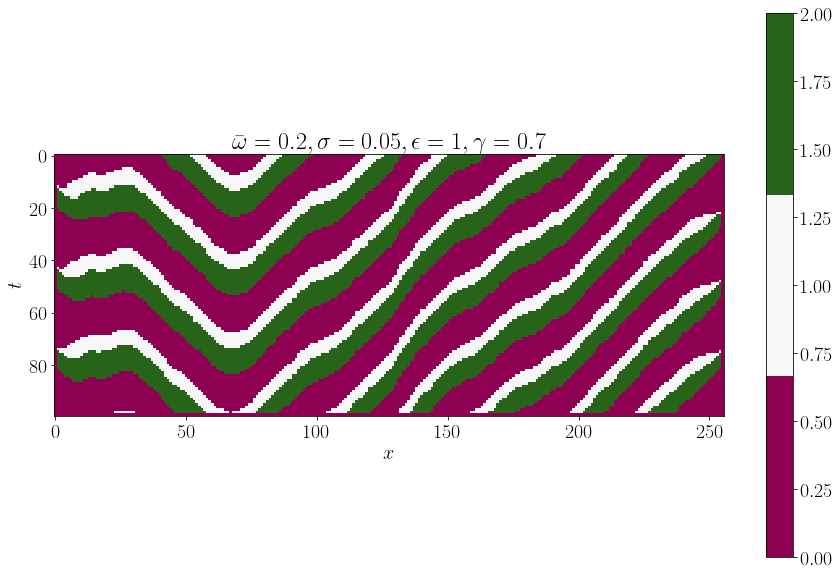

In [85]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)

phases = model.res[-100:] % (np.pi*2)

breakpoints = [x*2*np.pi for x in [0.47, 0.67]]
indexed_phases = np.zeros_like(phases) 
indexed_phases[phases > breakpoints[0]] = 1 
indexed_phases[phases > breakpoints[1]] = 2 

cmap = cm.get_cmap('PiYG', 3)  
im = plt.imshow(indexed_phases, cmap=cmap)
cbar = plt.colorbar(im)
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

## Next, we set up and run some 2D simulations 

In [5]:
# Set up model parameters 
epsilon = 1 
gamma = 0.4
sigma = 0.3
mean_omega = 1 

# Set up simulation parameters 
Lx = 128
Ly = 20
T = 1e2
dt = 1e-2
n_batches = T

# Initialise the model and run the simulation 
model = Kuramoto2D(epsilon, gamma, sigma, mean_omega)
model.initialise(Lx, Ly, T, dt, n_batches)
model.evolve() 

## Make movie of the 2D simulation 

In [6]:
# Reshape the result into 2D shape 
phase_evolution = model.res.reshape((model.n_batches, model.Lx, model.Ly))

# Set up figure plotting 
fig = plt.figure(figsize=(20, 5))
low, high = 0, 2*np.pi 

plt.rc('font', size=20)
plt.rc('text', usetex=True)

# Plot the movie one snapshot at a time 
ims = []
im = plt.imshow(phase_evolution[0].T, vmin=low, vmax=high, animated=True, cmap='twilight')
plt.title(r'$\sigma={}, \epsilon ={}, \gamma ={}$'.format(sigma, epsilon, gamma))
plt.axis('off')
cbar = plt.colorbar(im, shrink=0.6)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'0', r'$2\pi$'])
plt.tight_layout()
for i in range(model.n_batches):
    xy = phase_evolution[i].T % 2*np.pi 
    im = plt.imshow(xy, vmin=low, vmax=high, animated=True, cmap='twilight')
    plt.axis('off')
    ims.append([im])
ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
mywriter = am.FFMpegWriter()
ani.save("movie.mp4", writer=mywriter)
plt.close()


## Now you will find a video called "movie.mp4" in the same folder